# Creating and simulating a DFBA model
This tutorial demonstrates how to build and simulate a DFBA model corresponding to the growth of a single strain of _Escherichia coli_ (based on the iJR904 genome-scale model) under anaerobic conditions with glucose and xylose as limiting carbon substrates. 

This example can be adapted to other DFBA models by modifying the choice of genome-scale model, relevant kinetic variables, and exchange fluxes. 

In [1]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

## 1. Dfba model
Specify path for loading file containing genome-scale metabolic model as [cobra.Model](https://cobrapy.readthedocs.io/en/latest/building_model.html) object and set GLPK as LP solver of choice. After that, instantiate object of class `DfbaModel` with cobrapy model.

In [ ]:
path_to_model = join(pardir, "sbml-models", "iJR904.xml.gz")
fba_model = read_sbml_model(path_to_model)
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

## 2. Kinetic Variables
Instantiate kinetic variables to appear in model. Default initial conditions are $0.0$, but can be set here if wanted (e.g., Oxygen). The last command adds kinetic variables to the model.

In [3]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Xyl = KineticVariable("Xylose")
Oxy = KineticVariable("Oxygen", initial_condition=0.24)
Eth = KineticVariable("Ethanol")

dfba_model.add_kinetic_variables([X, Gluc, Xyl, Oxy, Eth])

## 3. Exchange fluxes
Instantiate exchange fluxes to appear in model, with ids corresponding to exchange reactions of the cobrapy FBA model. The last command adds exchange fluxes to the model.

In [4]:
mu = ExchangeFlux("BiomassEcoli")
v_G = ExchangeFlux("EX_glc(e)")
v_Z = ExchangeFlux("EX_xyl_D(e)")
v_O = ExchangeFlux("EX_o2(e)")
v_E = ExchangeFlux("EX_etoh(e)")

dfba_model.add_exchange_fluxes([mu, v_G, v_Z, v_O, v_E])

## 4. Rhs expressions 
Provide symbolic expression for calculating the time derivative of each kinetic variable currently in the model.

In [5]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559 * X / 1000.0)
dfba_model.add_rhs_expression("Xylose", v_Z * 150.13 * X / 1000.0)
dfba_model.add_rhs_expression("Oxygen", v_O * 16.0 * X / 1000.0)
dfba_model.add_rhs_expression("Ethanol", v_E * 46.06844 * X / 1000.0)

## 5. Lower/upper bound expressions 
Add symbolic expressions for calculating lower/upper bounds of selected exchange fluxes
currently in the model. Here convention is that both lower and upper bound expressions have 
positive signs, whereas lower bounds values are typically negative in cobrapy. 

In many applications, vector components (e.g., concentrations)
in the true solution are always positive or non-negative, though at times very
small.  In the numerical solution, however, small negative (hence unphysical)
values can then occur. To prevent these from interfering with the simulation,
the user can supply a symbolic expression that must be non-negative for
correct evaluation of lower/upper bounds.

In [6]:
dfba_model.add_exchange_flux_lb(
    "EX_glc(e)", 10.5 * (Gluc / (0.0027 + Gluc)) * (1 / (1 + Eth / 20.0)), Gluc
)
dfba_model.add_exchange_flux_lb("EX_o2(e)", 15.0 * (Oxy / (0.024 + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb(
    "EX_xyl_D(e)",
    6.0
    * (Xyl / (0.0165 + Xyl))
    * (1 / (1 + Eth / 20.0))
    * (1 / (1 + Gluc / 0.005)),
    Xyl,
)

## 6. Add initial conditions to the model and launch the simulation
Initial values for each kinetic variable are provided in dictionary form. 

The model is simulated using the `simulate` method. This simulation covers the interval $[0.0, 25.0]$ hours, with results stored every $0.1$ hours. Results (trajectories of kinetic variables) will be returned as [pandas.DataFrame](https://pandas.pydata.org/). Optionally, the user can also provide a list of reaction ids whose flux trajectories will also be returned as a separate [pandas.DataFrame](https://pandas.pydata.org/), in this case three exchange fluxes in the model.

In [7]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.03,
        "Glucose": 15.5,
        "Xylose": 8.0,
        "Oxygen": 0.0,
        "Ethanol": 0.0,
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 25.0, 0.1, ["EX_glc(e)", "EX_xyl_D(e)", "EX_etoh(e)"])

## 7. Plotting the results
<div class="alert alert-info">

**Note:** In order to plot the results, one of [plotly](https://plot.ly/python/) or [matplotlib](https://matplotlib.org/) should be used. See [Visualization](plotting.rst) to install them along with
dfba.

</div>



### Plotly
The functions for plotting with `plotly` returns a `plotly.graph_object`. Users of this library may plot the output with the usual functions.

In [8]:
from dfba.plot.plotly import *

import plotly.io as pio

# in plotly version 4, default version is different than in 3
pio.templates.default = "plotly_white"

In [9]:
fig = plot_concentrations(concentrations)
fig.show()

In [10]:
fig = plot_trajectories(trajectories)
fig.show()

### Matplotlib
We can use the `matplotlib` backend with the same functions.

In [11]:
from dfba.plot.matplotlib import *

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 16, 9

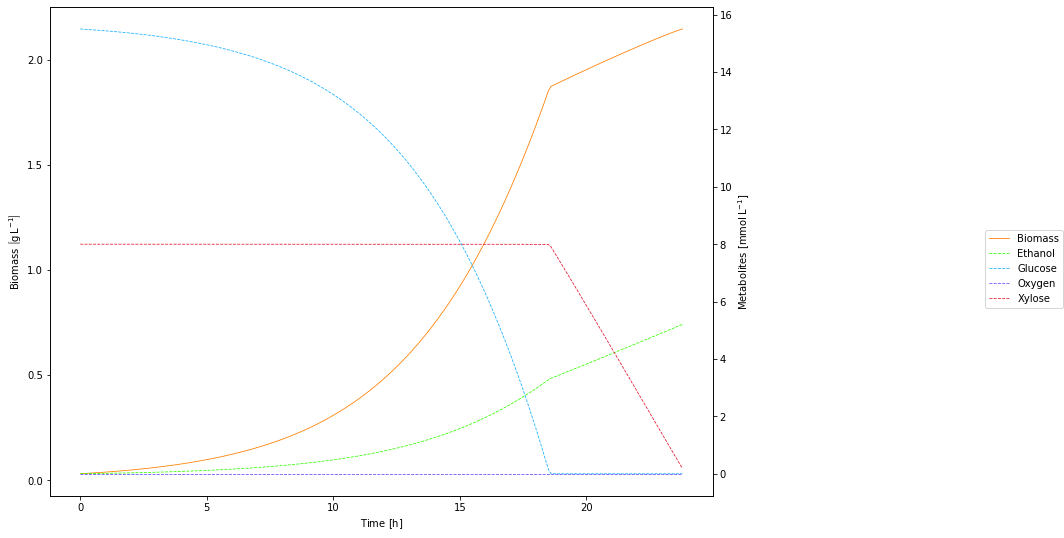

In [13]:
plot_concentrations(concentrations)
plt.show()

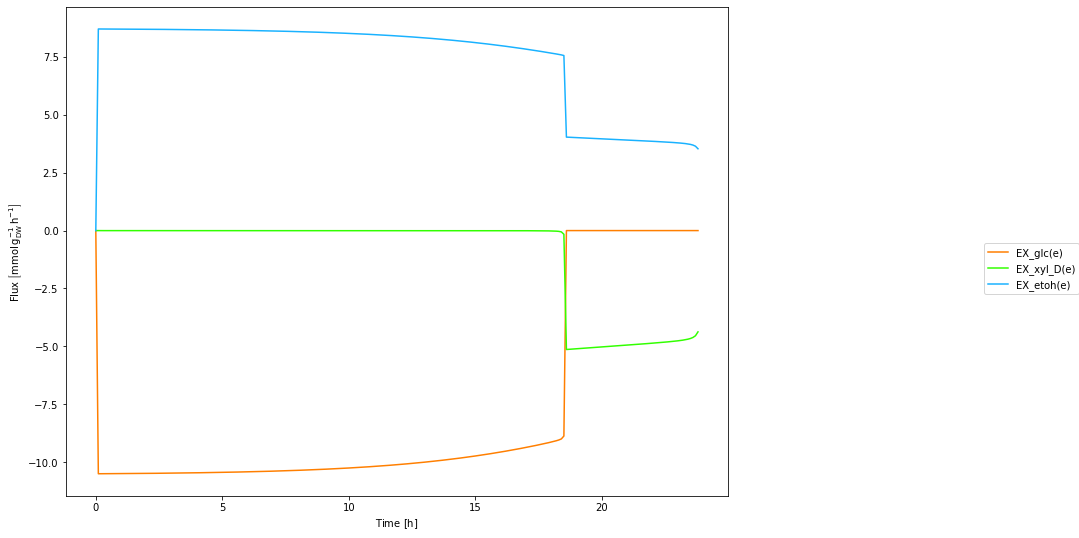

In [14]:
plot_trajectories(trajectories)
plt.show()

## 8. Writing the results to file

Particularly when running a simulation using [Docker](https://www.docker.com/) (see [Installation](installation.rst)), it can be useful to write 
results to a csv file for downstream analysis. This can be achieved using the [pandas.DataFrame](https://pandas.pydata.org/) method `to_csv()`




In [15]:
concentrations.to_csv("concentrations.csv")
trajectories.to_csv("trajectories.csv")